In [1]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
import random
from datetime import datetime, timedelta

@dataclass
class User:
    user_id: int
    age: int
    is_mobile: bool
    country: str
    customer_segment: str
    
@dataclass
class Touchpoint:
    name: str
    base_conversion_rate: float
    segment_multipliers: Dict[str, float]  # Multiplier for each customer segment
    position_effect: Dict[int, float]  # Multiplier based on position in journey
    
class JourneyGenerator:
    def __init__(
        self,
        seed: int = 42,
        max_journey_length: int = 10,
        max_journeys_per_user: int = 5
    ):
        self.random = np.random.RandomState(seed)
        self.max_journey_length = max_journey_length
        self.max_journeys_per_user = max_journeys_per_user
        
        # Define channels/touchpoints
        self.touchpoints = {
            'email': Touchpoint(
                name='email',
                base_conversion_rate=0.02,
                segment_multipliers={
                    'high_value': 1.5,
                    'medium_value': 1.0,
                    'low_value': 0.8
                },
                position_effect={
                    0: 0.5,  # Less effective as first touch
                    1: 1.2,  # More effective as second touch
                    2: 1.0,
                    3: 0.8,
                    4: 0.7
                }
            ),
            'social': Touchpoint(
                name='social',
                base_conversion_rate=0.015,
                segment_multipliers={
                    'high_value': 1.2,
                    'medium_value': 1.0,
                    'low_value': 0.9
                },
                position_effect={
                    0: 1.2,  # More effective as first touch
                    1: 1.0,
                    2: 0.8,
                    3: 0.7,
                    4: 0.6
                }
            ),
            'search': Touchpoint(
                name='search',
                base_conversion_rate=0.03,
                segment_multipliers={
                    'high_value': 1.3,
                    'medium_value': 1.0,
                    'low_value': 0.7
                },
                position_effect={
                    0: 1.5,  # Much more effective as first touch
                    1: 1.2,
                    2: 1.0,
                    3: 0.8,
                    4: 0.7
                }
            ),
            'retargeting': Touchpoint(
                name='retargeting',
                base_conversion_rate=0.04,
                segment_multipliers={
                    'high_value': 1.4,
                    'medium_value': 1.0,
                    'low_value': 3
                },
                position_effect={
                    0: 0.1,  # Very ineffective as first touch
                    1: 0.8,
                    2: 1.2,
                    3: 1.5,  # Most effective in middle of journey
                    4: 1.0
                }
            ),
            'direct': Touchpoint(
                name='direct',
                base_conversion_rate=0.05,
                segment_multipliers={
                    'high_value': 1.3,
                    'medium_value': 5,
                    'low_value': 0.8
                },
                position_effect={
                    0: 1.0,
                    1: 1.0,
                    2: 1.0,
                    3: 1.0,
                    4: 1.0
                }
            )
        }
        
    def generate_users(self, num_users: int) -> List[User]:
        """Generate a list of users with realistic attributes"""
        users = []
        for i in range(num_users):
            age = self.random.normal(35, 12)  # Age distribution centered at 35
            age = max(18, min(80, int(age)))  # Clip to reasonable range
            
            users.append(User(
                user_id=i,
                age=age,
                is_mobile=self.random.choice([True, False], p=[0.6, 0.4]),
                country=self.random.choice(['US', 'UK', 'DE', 'FR', 'ES']),
                customer_segment=self.random.choice(
                    ['high_value', 'medium_value', 'low_value'],
                    p=[0.2, 0.5, 0.3]
                )
            ))
        return users
    
    def calculate_conversion_probability(
        self,
        touchpoint: Touchpoint,
        position: int,
        user: User,
        previous_touchpoints: List[str]
    ) -> float:
        """Calculate conversion probability based on multiple factors"""
        prob = touchpoint.base_conversion_rate
        
        # Apply position effect
        position_mult = touchpoint.position_effect.get(
            min(position, max(touchpoint.position_effect.keys())),
            min(touchpoint.position_effect.values())
        )
        prob *= position_mult
        
        # Apply segment multiplier
        prob *= touchpoint.segment_multipliers[user.customer_segment]
        
        # Age effect
        if user.age < 30:
            if touchpoint.name in ['social', 'search']:
                prob *= 3
            elif touchpoint.name == 'email':
                prob *= 0.8
        elif user.age > 50:
            if touchpoint.name in ['social', 'search']:
                prob *= 0.8
            elif touchpoint.name == 'email':
                prob *= 3
                
        # Mobile effect
        if user.is_mobile:
            if touchpoint.name in ['social', 'search']:
                if 'search' in previous_touchpoints:
                    prob *= 3
                prob *= 2
            elif touchpoint.name == 'email':
                prob *= 0.9
                
        # Previous touchpoint effects
        if previous_touchpoints:
            if touchpoint.name == 'retargeting' and 'search' in previous_touchpoints[-2:]:
                prob *= 1.3
            if touchpoint.name == 'email' and 'social' in previous_touchpoints[-2:]:
                prob *= 3
            if touchpoint.name == 'search' and 'retargeting' in previous_touchpoints[-2:]:
                prob *= 5
                
        return min(prob, 1.0)  # Cap at 100%
    
    def generate_journey(self, user: User, journey_id: int) -> List[Dict]:
        """Generate a single customer journey for a user"""
        journey = []
        previous_touchpoints = []
        
        # Determine journey length
        max_length = self.random.geometric(p=0.2)  # Geometric distribution for length
        max_length = min(max_length, self.max_journey_length)
        
        for position in range(max_length):
            # Select touchpoint
            if position == 0:
                # First position has different probabilities
                touchpoint_name = self.random.choice(
                    list(self.touchpoints.keys()),
                    p=[0.25, 0.25, 0.2, 0.1, 0.2]  # Adjusted to include turbo
                )
            else:
                # Subsequent positions depend on previous touchpoint
                if previous_touchpoints[-1] == 'search':
                    # More likely to do retargeting after search
                    probs = [0.15, 0.15, 0.1, 0.4, 0.2]  # Added turbo probability
                elif previous_touchpoints[-1] == 'social':
                    # More likely to do email after social
                    probs = [0.35, 0.15, 0.1, 0.2, 0.2]  # Added turbo probability
                else:
                    probs = [0.2, 0.2, 0.2, 0.2, 0.2]  # Equal distribution
                    
                touchpoint_name = self.random.choice(
                    list(self.touchpoints.keys()),
                    p=probs
                )
            
            touchpoint = self.touchpoints[touchpoint_name]
            
            # Calculate conversion probability
            conv_prob = self.calculate_conversion_probability(
                touchpoint, position, user, previous_touchpoints
            )

            if conv_prob > 0.1:
                print(f"Conversion probability for {touchpoint_name} at position {position} is {conv_prob}")
            
            # Determine if conversion happened
            converted = self.random.random() < conv_prob
            
            # Add to journey
            journey.append({
                'user_id': user.user_id,
                'touchpoint': touchpoint_name,
                'position': position,
                'converted': converted,
                'journey_id': journey_id,
                'conversion_probability': conv_prob,
                'timestamp': None  # Will be filled in later
            })
            
            previous_touchpoints.append(touchpoint_name)
            
            if converted:
                break
                
        return journey
    
    def generate_dataset(self, num_users: int) -> pd.DataFrame:
        """Generate complete dataset of users and their journeys"""
        users = self.generate_users(num_users)
        
        # Generate journeys
        all_journeys = []
        base_timestamp = datetime(2023, 1, 1)
        
        journey_id = 0
        for user in users:
            # Determine number of journeys for this user
            num_journeys = self.random.randint(1, self.max_journeys_per_user + 1)
            
            for journey_idx in range(num_journeys):
                journey_id += 1
                journey = self.generate_journey(user, journey_id)
                
                # Add timestamps
                journey_start = base_timestamp + timedelta(
                    days=self.random.randint(0, 365)
                )
                
                for i, touch in enumerate(journey):
                    # Add some random hours between touchpoints
                    touch['timestamp'] = journey_start + timedelta(
                        hours=self.random.randint(i * 24, (i + 1) * 24)
                    )
                
                all_journeys.extend(journey)
        
        # Create main journey DataFrame
        journey_df = pd.DataFrame(all_journeys)
        
        # Create user DataFrame
        user_df = pd.DataFrame([{
            'user_id': user.user_id,
            'age': user.age,
            'is_mobile': user.is_mobile,
            'country': user.country,
            'customer_segment': user.customer_segment
        } for user in users])
        
        return journey_df, user_df

# Example usage
generator = JourneyGenerator(seed=42)
journey_df, user_df = generator.generate_dataset(num_users=1000)

# Save to CSV
journey_df.to_csv('customer_journeys.csv', index=False)
user_df.to_csv('users.csv', index=False)

# Print example journeys for one user
print("\nExample journeys for first user:")
print(journey_df[journey_df['user_id'] == 0])

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total users: {len(user_df)}")
print(f"Total touchpoints: {len(journey_df)}")
print(f"Average journey length: {len(journey_df) / len(user_df):.2f}")
print(f"Conversion rate: {journey_df['converted'].mean():.3f}")

Conversion probability for search at position 3 is 0.12
Conversion probability for direct at position 1 is 0.25
Conversion probability for direct at position 2 is 0.25
Conversion probability for search at position 3 is 0.24
Conversion probability for direct at position 5 is 0.25
Conversion probability for direct at position 0 is 0.25
Conversion probability for retargeting at position 2 is 0.14400000000000002
Conversion probability for retargeting at position 3 is 0.18
Conversion probability for retargeting at position 4 is 0.12
Conversion probability for search at position 5 is 0.22049999999999997
Conversion probability for search at position 4 is 0.1638
Conversion probability for search at position 5 is 0.4914
Conversion probability for search at position 6 is 0.4914
Conversion probability for search at position 9 is 1.0
Conversion probability for social at position 0 is 0.1296
Conversion probability for social at position 0 is 0.1296
Conversion probability for social at position 1 is

<Axes: >

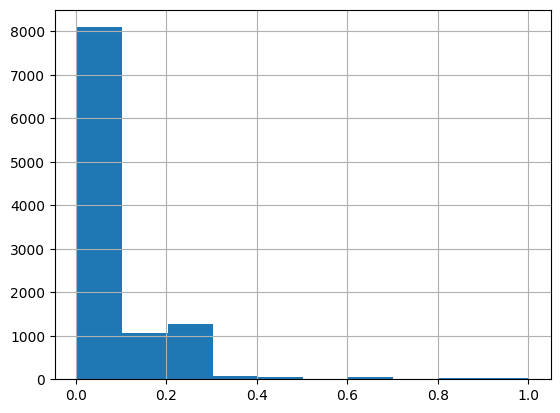

In [2]:
journey_df.conversion_probability.hist()

## Modeling

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [4]:
max_length = journey_df.position.max() + 1

In [5]:
enc = OrdinalEncoder()
transf = enc.fit_transform(journey_df.touchpoint.values.reshape(-1, 1))

journey_df['touchpoint_encoded'] = transf.astype(int)


In [6]:
journeys = journey_df.groupby('journey_id').agg(
    journey_list = ('touchpoint_encoded', lambda x: x.tolist() + [0] * (max_length - len(x))),
    converted = ('converted', 'any'),
    user_id = ('user_id', 'first')
)

y = torch.tensor(journey_df.groupby('journey_id').agg(
    converted = ('converted', 'any')
).converted.values, dtype=torch.float)

journeys = journeys.merge(user_df, on='user_id')

In [7]:
class JourneyLSTM(nn.Module):
    def __init__(self, extra_dim:int, journey_dim:int, num_channels: int, hidden_size: int = 64, num_layers: int = 2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.journey_dim = journey_dim
        self.extra_dim = extra_dim
        
        # Embedding layer for channel types
        self.channel_embedding = nn.Embedding(num_channels, hidden_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size + extra_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x:torch.Tensor, lengths=None):
        # x shape: (batch_size, seq_length)
        # Embed channels
        embedded = self.channel_embedding(x[:, -self.journey_dim:].long())  # (batch_size, seq_length, hidden_size)
        
        if lengths is not None:
            # Pack padded sequence
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths, batch_first=True, enforce_sorted=False
            )
            # Process through LSTM
            lstm_out, _ = self.lstm(packed)
            # Unpack
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        else:
            lstm_out, _ = self.lstm(embedded)
        
        # Get final output
        final_hidden = lstm_out[:, -1, :]  # Take last timestep
        out = self.sigmoid(self.fc(torch.cat((final_hidden, x[:, :-self.journey_dim]), dim=1)))
        return out

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), ['age']),
    ('cat_encoder', OneHotEncoder(), ['is_mobile', 'customer_segment', 'country']),
    # ('journey', 'passthrough', ['journey_list'])

])
X = torch.tensor(transformer.fit_transform(journeys), dtype=torch.float)
X_journey = torch.tensor(np.stack(journeys.journey_list), dtype=torch.long)

journey_dim = X_journey.shape[1]

In [9]:
X = torch.cat((X, X_journey), dim=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

In [71]:
num_channels = len(generator.touchpoints)
extra_dim = X_train.shape[1] - journey_dim
model = JourneyLSTM(num_channels=num_channels, journey_dim=journey_dim, extra_dim=extra_dim)

loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
import torch.optim as optim
import torch.utils.data as data

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64)

In [ ]:
test_recalls = []

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        # Training metrics
        y_pred = model(X_train)
        y_pred_round = y_pred.round()
        train_acc = (y_pred_round == y_train).float().mean()
        train_recall = ((y_pred_round == 1) & (y_train == 1)).sum() / (y_train == 1).sum()

        # Test metrics
        y_pred = model(X_test)
        y_pred_round = y_pred.round()
        test_acc = (y_pred_round == y_test).float().mean()
        test_recall = ((y_pred_round == 1) & (y_test == 1)).sum() / (y_test == 1).sum()
        test_recalls.append(test_recall)
        

    print("Epoch %d: train acc %.4f, train recall %.4f, test acc %.4f, test recall %.4f" % 
          (epoch, train_acc, train_recall, test_acc, test_recall))

Text(0, 0.5, 'Recall')

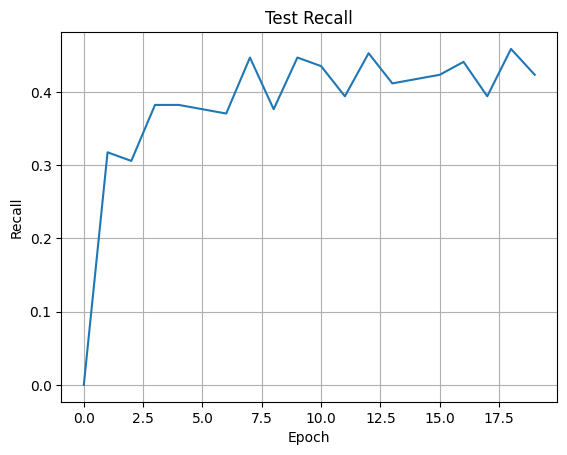

In [74]:
test_recalls = np.array(test_recalls)

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(x=np.arange( n_epochs / 10), y=test_recalls, ax=ax)
ax.set_title('Test Recall')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_ylabel('Recall')

## Optimization

In [95]:
custom_set = journeys.sample(10)
channels_fixed = []
custom_set['imposed_journey_list'] = [ channels_fixed + [0] * (max_length - len(channels_fixed))] * len(custom_set)
custom_set.drop(columns=['journey_list'], inplace=True)
X_custom = torch.tensor(transformer.transform(custom_set), dtype=torch.float)
X_custom_journey = torch.tensor(np.stack(custom_set.imposed_journey_list), dtype=torch.long)
X_custom = torch.cat((X_custom, X_custom_journey), dim=1)
custom_set['pred_conv_prob'] = model(X_custom).detach().numpy().flatten()


In [100]:
pos = 0

In [ ]:
# Select a user whose features we want to keep fixed
user_idx = 0
fixed_features = X_custom[user_idx:user_idx+1, :extra_dim].clone()  # Keep user features fixed

# Only optimize the journey part
journey_opt = torch.rand(1, journey_dim, requires_grad=True)  # Only journey dimensions
optimizer = optim.Adam([journey_opt], lr=0.01)

num_iterations = 100
for i in range(num_iterations):
    print(journey_opt)
    optimizer.zero_grad()
    
    # Combine fixed features with optimizable journey
    X_combined = torch.cat((fixed_features, journey_opt), dim=1)
    
    # Forward pass
    pred = model(X_combined)
    
    # Loss is negative prediction (since we want to maximize)
    loss = -pred.mean()
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Iteration {i}, Predicted conversion probability: {-loss.item():.4f}")

In [111]:
touchpoint_probs = torch.nn.Parameter(torch.rand(X_custom.shape[0], num_channels, requires_grad=True))
optimizer = optim.Adam([touchpoint_probs], lr=0.1)

num_iterations = 10

for i in range(num_iterations):

    print(touchpoint_probs)

    X_ = X_custom.clone()

    optimizer.zero_grad()
    
    # Softmax to get probabilities for each channel
    sequence_probs = F.softmax(touchpoint_probs, dim=1)
    touchpoint = torch.multinomial(sequence_probs, 1).squeeze()

    X_[: , extra_dim+pos] = touchpoint

    pred = model(X_)
    loss = -pred.mean()
    print(loss)
    loss.backward()
    optimizer.step()


Parameter containing:
tensor([[0.0836, 0.7072, 0.6594, 0.1299, 0.7132],
        [0.5431, 0.3623, 0.4124, 0.9950, 0.8230],
        [0.6087, 0.8488, 0.5166, 0.5257, 0.2037],
        [0.8466, 0.8939, 0.3547, 0.9492, 0.8392],
        [0.8559, 0.0534, 0.8523, 0.5563, 0.9631],
        [0.4617, 0.7495, 0.1198, 0.5626, 0.1231],
        [0.8585, 0.1929, 0.9054, 0.8756, 0.5808],
        [0.6940, 0.9239, 0.9526, 0.3969, 0.6005],
        [0.7841, 0.8586, 0.0792, 0.8696, 0.9117],
        [0.2969, 0.9806, 0.5321, 0.8925, 0.9063]], requires_grad=True)
tensor(-0.1494, grad_fn=<NegBackward0>)
Parameter containing:
tensor([[0.0836, 0.7072, 0.6594, 0.1299, 0.7132],
        [0.5431, 0.3623, 0.4124, 0.9950, 0.8230],
        [0.6087, 0.8488, 0.5166, 0.5257, 0.2037],
        [0.8466, 0.8939, 0.3547, 0.9492, 0.8392],
        [0.8559, 0.0534, 0.8523, 0.5563, 0.9631],
        [0.4617, 0.7495, 0.1198, 0.5626, 0.1231],
        [0.8585, 0.1929, 0.9054, 0.8756, 0.5808],
        [0.6940, 0.9239, 0.9526, 0.3969, 0.60

In [ ]:
def optimize_sequence(model, user_features, num_channels, num_iterations=100, lr=0.1):
    # Create initial random sequence
    sequence = torch.rand(num_channels, requires_grad=True)
    optimizer = optim.Adam([sequence], lr=lr)
    
    # Combine with user features
    fixed_features = user_features.repeat(1, 1)
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Softmax to get probabilities for each channel
        sequence_probs = F.softmax(sequence, dim=1)
        
        print(sequence_probs)

        # Create input by concatenating features and sequence
        model_input = torch.cat((fixed_features, sequence_probs), dim=1)
        
        # Get prediction
        pred = model(model_input)
        
        # Maximize probability (minimize negative probability)
        loss = -pred
        
        loss.backward()
        optimizer.step()
    
    # Convert to channel indices
    optimal_sequence = torch.argmax(F.softmax(sequence, dim=1), dim=1)
    return optimal_sequence, pred.item()

# Example usage for a single user
user_idx = 0
user_features = X[user_idx:user_idx+1, :-journey_dim]  # Get user features without journey
optimal_sequence, pred_prob = optimize_sequence(model, user_features)

print(optimal_sequence)

# Convert sequence back to channel names
channel_names = [enc.inverse_transform([[idx.item()]])[0][0] for idx in optimal_sequence]
print(f"Optimal sequence: {channel_names}")
print(f"Predicted conversion probability: {pred_prob:.3f}")